In [49]:
import os    
#os.environ['THEANO_FLAGS'] = "device=gpu1"  
#os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu0,floatX=float32,lib.cnmem=1"
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu0,floatX=float32"

from keras.layers import Input, Dense, convolutional,Reshape, Flatten, LeakyReLU, BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



In [78]:
img_rows, img_cols = 32, 32

nb_filters_1 = 96
nb_filters_2 = 192
nb_filters_3 = 256
nb_conv = 1
nb_conv_mid = 3
nb_conv_init = 5

In [79]:
def conv(init, nb_filter, row, col, subsample=(1,1), repeat=0):
    c = convolutional.Convolution2D(nb_filter, row, col, border_mode='same', subsample=subsample)(init)
    c = LeakyReLU()(c)

    for i in range(repeat):
        c = convolutional.Convolution2D(nb_filter, row, col, border_mode='same', subsample=subsample)(c)
        c = LeakyReLU()(c)
    return c

init = Input(shape=(3, img_rows, img_cols),)

fork11 = conv(init, nb_filters_1, nb_conv_init, nb_conv_init, repeat=1)
fork12 = conv(init, nb_filters_1, nb_conv_mid, nb_conv_mid, repeat=1)
merge1 = merge([fork11, fork12, ], mode='concat', concat_axis=1)
conv_pool1 = conv(merge1, nb_filters_1, nb_conv_init, nb_conv_init, subsample=(2,2))
bn1 = BatchNormalization(axis=1)(conv_pool1)

fork21 = conv(bn1, nb_filters_2, nb_conv_mid, nb_conv_mid, repeat=1)
fork22 = conv(bn1, nb_filters_2, nb_conv_mid, nb_conv_mid, repeat=1)
merge2 = merge([fork21, fork22, ], mode='concat', concat_axis=1)
conv_pool2 = conv(merge2, nb_filters_2, nb_conv_mid, nb_conv_mid, subsample=(2,2))
bn2 = BatchNormalization(axis=1)(conv_pool2)

fork31 = conv(bn2, nb_filters_3, nb_conv_mid, nb_conv_mid)
fork32 = conv(bn2, nb_filters_3, nb_conv, nb_conv)
fork33 = conv(bn2, nb_filters_3, nb_conv_init, nb_conv_init)
merge3 = merge([fork31, fork32, fork33, ], mode='concat', concat_axis=1)
conv_pool3 = conv(merge3, nb_filters_2, nb_conv_mid, nb_conv_mid, subsample=(2,2))
dropout = Dropout(0.5)(conv_pool3)

flatten = Flatten()(dropout)
output = Dense(10, activation="softmax")(flatten)

autoencoder = Model(input=init, output=output)
autoencoder.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# this is our input placeholder
input_img = Input(shape=(3,32,32))

x = convolutional.Convolution2D(32, 5, 5, activation='relu', border_mode='same')(input_img)
x = convolutional.MaxPooling2D((2, 2), border_mode='same')(x)
x = convolutional.Convolution2D(64, 3, 3, activation='relu', border_mode='same')(x)
x = convolutional.MaxPooling2D((2, 2), border_mode='same')(x)
x = convolutional.Convolution2D(128, 3, 3, activation='relu', border_mode='same')(x)
encoded = convolutional.MaxPooling2D((2, 2), border_mode='same')(x)

#x = convolutional.UpSampling2D((2, 2))(encoded)
#x = convolutional.Convolution2D(20, 5, 5, activation='relu', border_mode='same')(x)
x = convolutional.Convolution2D(128, 3, 3, activation='relu', border_mode='same')(encoded)
x = convolutional.UpSampling2D((2, 2))(x)
x = convolutional.Convolution2D(64, 3, 3, activation='relu', border_mode='same')(x)
x = convolutional.UpSampling2D((2, 2))(x)
x = convolutional.Convolution2D(32, 5, 5, activation='relu',border_mode='same')(x)
x = convolutional.UpSampling2D((2, 2))(x)
#x = Flatten()(x)
#x = Dense(3072, activation='linear')(x)
#decoded = Reshape((3,32,32))(x)
decoded = convolutional.Convolution2D(3, 5, 5, activation='sigmoid', border_mode='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy',metrics=['accuracy'])

In [80]:
init = Input(shape=(3, img_rows, img_cols),)

fork11 = conv(init, nb_filters_1, nb_conv_init, nb_conv_init)
conv_pool1 = conv(fork11, nb_filters_1, nb_conv_init, nb_conv_init)
conv_pool1 = convolutional.MaxPooling2D((2, 2), border_mode='same')(conv_pool1)

fork21 = conv(conv_pool1, nb_filters_2, nb_conv_mid, nb_conv_mid)
conv_pool2 = conv(fork21, nb_filters_2, nb_conv_mid, nb_conv_mid)
conv_pool2 = convolutional.MaxPooling2D((2, 2), border_mode='same')(conv_pool2)

fork31 = conv(conv_pool2, nb_filters_3, nb_conv_mid, nb_conv_mid)
conv_pool3 = conv(fork31, nb_filters_2, nb_conv_mid, nb_conv_mid)

encoded = convolutional.MaxPooling2D((2, 2), border_mode='same')(conv_pool3)

conv_poold13d = conv(encoded, nb_filters_2, nb_conv_mid, nb_conv_mid)
fork13d = conv(conv_poold13d, nb_filters_3, nb_conv_mid, nb_conv_mid)

ups13d = convolutional.UpSampling2D((2, 2))(fork13d)
conv_pool2d = conv(ups13d, nb_filters_2, nb_conv_mid, nb_conv_mid)
fork12d = conv(conv_pool2d, nb_filters_2, nb_conv_mid, nb_conv_mid)

ups12d = convolutional.UpSampling2D((2, 2))(fork12d)
conv_pool1d = conv(ups12d, nb_filters_1, nb_conv_init, nb_conv_init)
ups11d = convolutional.UpSampling2D((2, 2))(conv_pool1d)

decoded = convolutional.Convolution2D(3, 5, 5, activation='sigmoid', border_mode='same')(ups11d)

autoencoder = Model(init, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy',metrics=['accuracy'])

In [81]:
print (autoencoder.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_11 (InputLayer)            (None, 3, 32, 32)     0                                            
____________________________________________________________________________________________________
convolution2d_65 (Convolution2D) (None, 96, 32, 32)    7296        input_11[0][0]                   
____________________________________________________________________________________________________
leakyrelu_48 (LeakyReLU)         (None, 96, 32, 32)    0           convolution2d_65[0][0]           
____________________________________________________________________________________________________
convolution2d_66 (Convolution2D) (None, 96, 32, 32)    230496      leakyrelu_48[0][0]               
___________________________________________________________________________________________

In [82]:
X_train=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/X_train.npy')
X_test=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/X_test.npy')
y_train=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/y_train.npy')
y_test=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/y_test.npy')

In [83]:
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


In [84]:
x_train = X_train.astype('float32') / 255.
x_test = X_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

(50000, 3072)
(10000, 3072)


In [85]:
x_train = x_train.reshape((len(x_train),3,32,32))
x_test = x_test.reshape((len(x_test),3,32,32))
print (x_train.shape)
print (x_test.shape)

(50000, 3, 32, 32)
(10000, 3, 32, 32)


In [87]:
# this model maps an input to its encoded representation
encoding_dim=40
encoded = Flatten()(encoded)
encoded = Dense(encoding_dim, activation='sigmoid')(encoded)
encoder = Model(init, encoded)

In [88]:
print (encoder.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_11 (InputLayer)            (None, 3, 32, 32)     0                                            
____________________________________________________________________________________________________
convolution2d_65 (Convolution2D) (None, 96, 32, 32)    7296        input_11[0][0]                   
____________________________________________________________________________________________________
leakyrelu_48 (LeakyReLU)         (None, 96, 32, 32)    0           convolution2d_65[0][0]           
____________________________________________________________________________________________________
convolution2d_66 (Convolution2D) (None, 96, 32, 32)    230496      leakyrelu_48[0][0]               
___________________________________________________________________________________________

In [65]:
X_train=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/X_train.npy')
X_test=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/X_test.npy')
y_train=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/y_train.npy')
y_test=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/y_test.npy')

In [66]:
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


In [67]:
x_train = X_train.astype('float32') / 255.
x_test = X_test.astype('float32') / 255.

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

(50000, 3072)
(10000, 3072)


In [68]:
x_train = x_train.reshape((len(x_train),3,32,32))
x_test = x_test.reshape((len(x_test),3,32,32))
print (x_train.shape)
print (x_test.shape)

(50000, 3, 32, 32)
(10000, 3, 32, 32)


In [89]:
nfold=5
nb_epoch=1
batch_size=256
random_state =5435

In [70]:
kfold_weights_path = os.path.join('weights_kfold_' + str(nfold) + 
                                  '_epoch_'+str(nb_epoch)+
                                  '_batch_'+str(batch_size)
                                  +'.h5')
print(kfold_weights_path)

weights_kfold_5_epoch_1_batch_256.h5


In [71]:
kf = KFold(len(x_train), n_folds=nfold, shuffle=True, random_state=random_state)
print(kf)

sklearn.cross_validation.KFold(n=50000, n_folds=5, shuffle=True, random_state=5435)


In [72]:
train_full_encoded_imgs = np.zeros(shape=[x_train.shape[0],encoding_dim])
print(train_full_encoded_imgs.shape)

test_full_encoded_imgs = np.zeros(shape=[x_test.shape[0],encoding_dim])
test_full_decoded_imgs = np.zeros(shape=[x_test.shape[0],3,32,32])
print(test_full_encoded_imgs.shape)
print(test_full_decoded_imgs.shape)

(50000, 40)
(10000, 40)
(10000, 3, 32, 32)


In [73]:
os.path.isfile(kfold_weights_path)

True

In [90]:
num_fold = 0
restore_from_last_checkpoint=0
for train_index,valid_index in kf:
    s_train,s_valid  = x_train[train_index], x_train[valid_index]
    
    #noise_factor = 0.1
    #s_train_noisy = s_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=s_train.shape) 
    #s_valid_noisy = s_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=s_valid.shape) 

    #s_train_noisy = np.clip(s_train_noisy, 0., 1.)
    #s_valid_noisy = np.clip(s_valid_noisy, 0., 1.)
    #y_train, y_test = y[train_index], y[test_index]
    
    num_fold += 1
    print('\n\nStart KFold number {} from {}'.format(num_fold, nfold))
    print('Split train: ', len(s_train), len(s_train))
    print('Split valid: ', len(s_train), len(s_valid))

    if not os.path.isfile(kfold_weights_path) or restore_from_last_checkpoint == 0:
        callbacks = [
                EarlyStopping(monitor='val_loss', patience=1, verbose=1),
                ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=1),
        ]
        autoencoder.fit(s_train, s_train,
                nb_epoch=nb_epoch,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(s_valid, s_valid),
                callbacks=callbacks)
    #if os.path.isfile(kfold_weights_path):
    #    autoencoder.load_weights(kfold_weights_path)
    
    # Store train predictions
    train_encoded_imgs = encoder.predict(x_train,batch_size=batch_size, verbose=1)
    train_full_encoded_imgs = np.add(train_full_encoded_imgs,train_encoded_imgs)

    
    # Store test predictions
    test_encoded_imgs = encoder.predict(x_test,batch_size=batch_size, verbose=1)
    #full_encoded_imgs = np.vstack([full_encoded_imgs,encoded_imgs])
    test_full_encoded_imgs = np.add(test_full_encoded_imgs,test_encoded_imgs)
    #full_encoded_imgs.append(encoded_imgs)
    #print(full_encoded_imgs.shape)
    
    test_decoded_imgs = autoencoder.predict(x_test,batch_size=batch_size, verbose=1)
    #full_decoded_imgs = np.vstack([full_decoded_imgs,decoded_imgs])
    test_full_decoded_imgs = np.add(test_full_decoded_imgs,test_decoded_imgs)






Start KFold number 1 from 5
Split train:  40000 40000
Split valid:  40000 10000
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
 5632/40000 [===>..........................] - ETA: 1315s - loss: 0.6901 - acc: 0.0607

KeyboardInterrupt: 

In [33]:
print(test_full_encoded_imgs.shape)
print(test_full_decoded_imgs.shape)
print(test_full_encoded_imgs)
print(test_full_decoded_imgs)


(10000, 40)
(10000, 3, 32, 32)
[[  5.50107155e-01  -2.22845016e-01  -3.42977807e-01 ...,   3.73362146e-01
   -3.57680018e-02  -4.31292348e-01]
 [  7.79024614e-02   3.79622541e-01   4.11981506e-01 ...,   1.57345018e+00
    1.34121482e+00   1.31824209e+00]
 [  3.98708928e-01   8.14659442e-02   2.91561412e-01 ...,   9.92630154e-01
    5.51055863e-01   1.00933264e+00]
 ..., 
 [ -2.43356042e-01   3.88308810e-02   3.28520909e-01 ...,   1.78427534e-01
    1.55385729e-01  -1.05426077e+00]
 [  5.40155191e-01  -2.72288112e-01  -7.53253698e-06 ...,   8.51636939e-03
    1.96926449e-02  -1.05648921e+00]
 [  2.46207606e-01  -2.02843208e-01  -3.12464028e-01 ...,   2.28415001e-01
    5.49414702e-01  -2.67400965e-01]]
[[[[ 2.1651592   2.07678244  1.96290785 ...,  2.04386705  2.08214504
     2.20396537]
   [ 2.00681686  1.90434119  1.78735876 ...,  1.89502659  1.98424569
     2.12067375]
   [ 2.0019134   1.86008844  1.73823917 ...,  1.86296397  1.94153261
     2.06584999]
   ..., 
   [ 2.28590927  2.212

In [34]:
test_res_encoded_imgs = test_full_encoded_imgs/nfold
test_res_decoded_imgs = test_full_decoded_imgs/nfold
print(test_res_encoded_imgs.shape)
print(test_res_decoded_imgs.shape)
print(test_res_encoded_imgs)
print(test_res_decoded_imgs)

(10000, 40)
(10000, 3, 32, 32)
[[  1.10021431e-01  -4.45690032e-02  -6.85955614e-02 ...,   7.46724293e-02
   -7.15360036e-03  -8.62584695e-02]
 [  1.55804923e-02   7.59245083e-02   8.23963013e-02 ...,   3.14690036e-01
    2.68242964e-01   2.63648418e-01]
 [  7.97417857e-02   1.62931888e-02   5.83122824e-02 ...,   1.98526031e-01
    1.10211173e-01   2.01866528e-01]
 ..., 
 [ -4.86712083e-02   7.76617620e-03   6.57041818e-02 ...,   3.56855068e-02
    3.10771458e-02  -2.10852154e-01]
 [  1.08031038e-01  -5.44576224e-02  -1.50650740e-06 ...,   1.70327388e-03
    3.93852899e-03  -2.11297843e-01]
 [  4.92415212e-02  -4.05686416e-02  -6.24928055e-02 ...,   4.56830002e-02
    1.09882940e-01  -5.34801930e-02]]
[[[[ 0.43303184  0.41535649  0.39258157 ...,  0.40877341  0.41642901
     0.44079307]
   [ 0.40136337  0.38086824  0.35747175 ...,  0.37900532  0.39684914
     0.42413475]
   [ 0.40038268  0.37201769  0.34764783 ...,  0.37259279  0.38830652
     0.41317   ]
   ..., 
   [ 0.45718185  0.442

In [35]:
train_res_encoded_imgs = train_full_encoded_imgs/nfold
print(train_res_encoded_imgs.shape)
print(train_res_encoded_imgs)

(50000, 40)
[[ 0.07519222 -0.05050889 -0.05780403 ..., -0.0147233   0.00978283
  -0.1985741 ]
 [ 0.17438371  0.00696768 -0.02236436 ...,  0.09274628  0.04625538
  -0.04535967]
 [-0.06428937  0.06557714  0.05764655 ...,  0.2736768   0.22419406
   0.19302378]
 ..., 
 [-0.0694421   0.08225722  0.1384349  ...,  0.19916391  0.1678891
   0.19243876]
 [ 0.1620671  -0.0887481  -0.04942572 ...,  0.19240197  0.02719276
   0.12158469]
 [-0.00932027 -0.00479772 -0.11427819 ...,  0.13147962  0.17393661
  -0.00466273]]


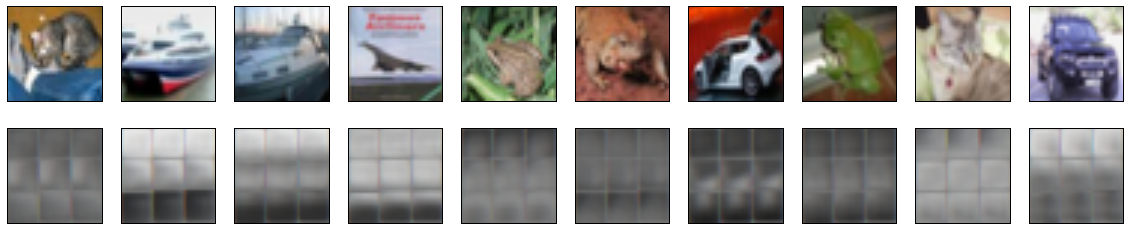

In [36]:
import matplotlib.pyplot as plt
test_res_decoded_imgs=test_res_decoded_imgs.reshape(10000,3,32,32)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    #ax = plt.subplot(1, n, i)
    #Plot the raw original image
    plt.imshow(x_test[i].reshape(32,32,3)) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(test_res_decoded_imgs[i].reshape(32,32,3))    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [37]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
clf = clf.fit(train_res_encoded_imgs, np.ravel(y_train))

In [38]:
y_pred = clf.predict(test_res_encoded_imgs)


In [39]:
num=len(test_res_encoded_imgs)
r=0
w=0
y_test = np.ravel(y_test)
for i in range(num):
        #print ('y_pred ',y_pred[i])
        #print ('labels ',labels[i])
        #without the use of all() returns error truth value of an array with more than one element is ambiguous
        #if y_pred[i].all() == labels[i].all():
        if np.array_equal(y_pred[i],y_test[i]):
            r+=1
        else:
            w+=1
print ("tested ",  num, "digits")
print ("correct: ", r, "wrong: ", w, "error rate: ", float(w)*100/(r+w), "%")
print ("got correctly ", float(r)*100/(r+w), "%")


tested  10000 digits
correct:  2692 wrong:  7308 error rate:  73.08 %
got correctly  26.92 %


In [40]:
y_pred

array([0, 0, 1, ..., 6, 7, 7])

In [41]:
y_test

array([3, 8, 8, ..., 5, 1, 7])